# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

Total images: 4752
Num classes : 9
Classes     : Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation


,count
label,
Cardboard,461
Food Organics,411
Glass,420
Metal,790
Miscellaneous Trash,495
Paper,500
Plastic,921
Textile Trash,318
Vegetation,436


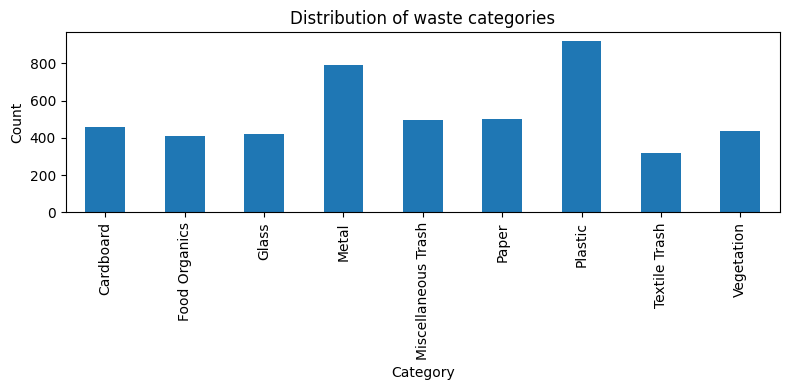

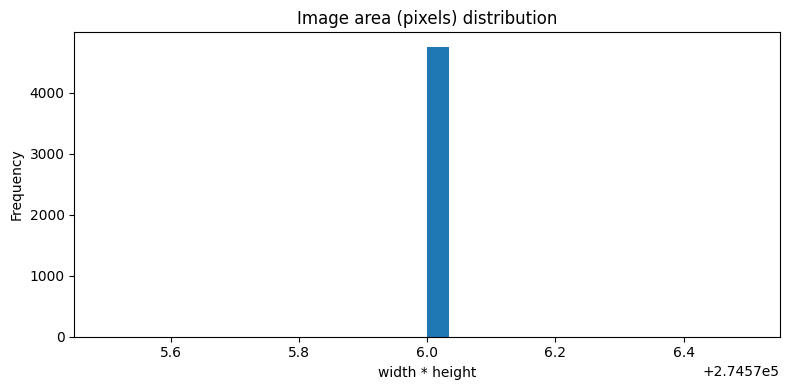

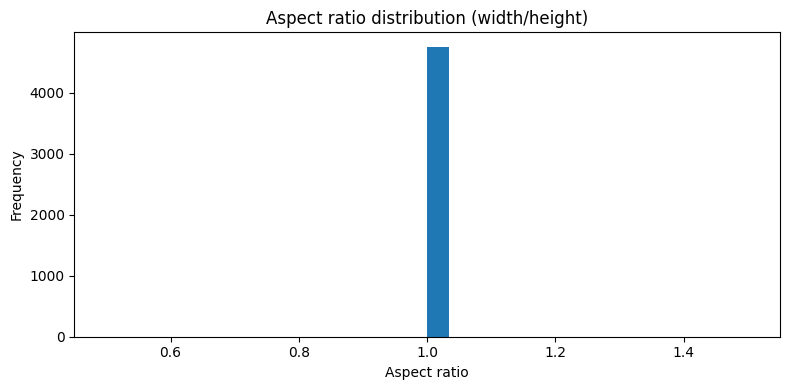

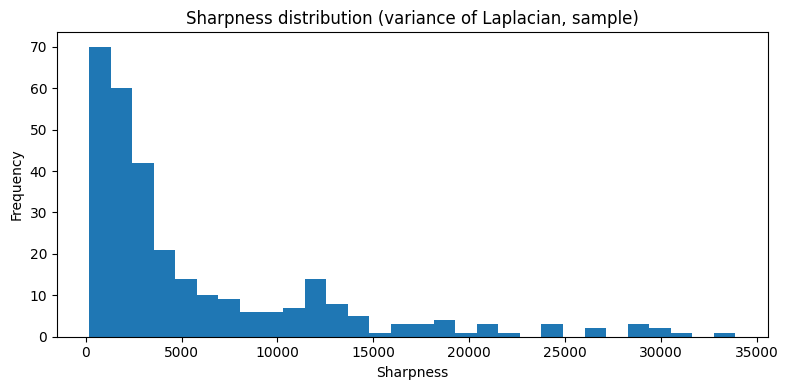

Sharpness (sample) — mean: 5786.964 median: 2956.986


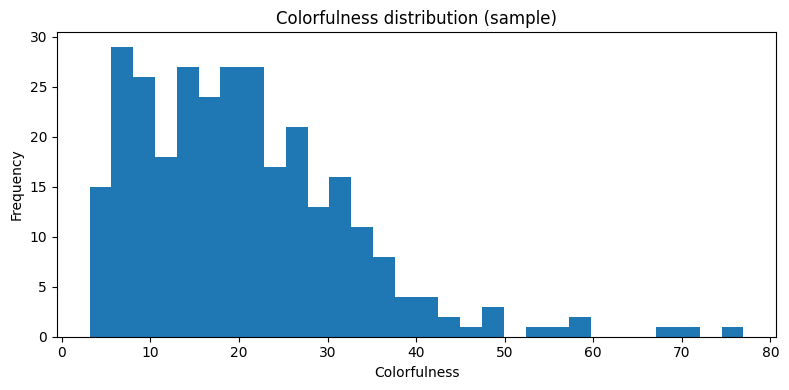

Colorfulness (sample) — mean: 20.485 median: 19.107


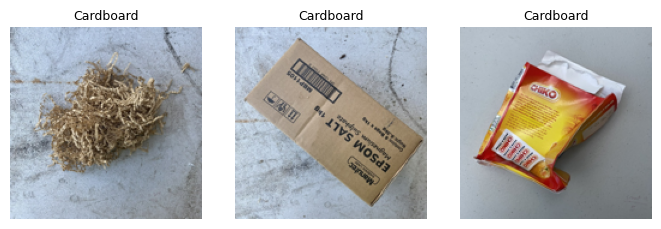

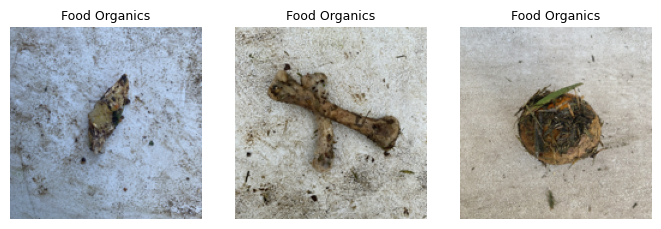

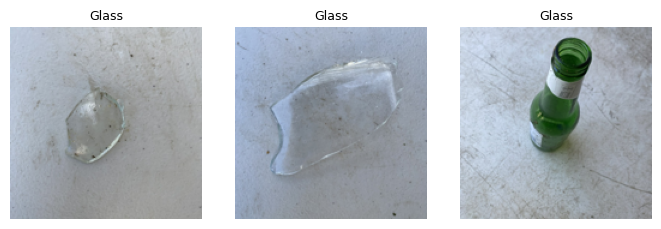

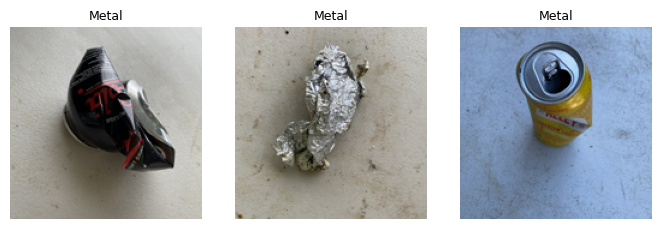

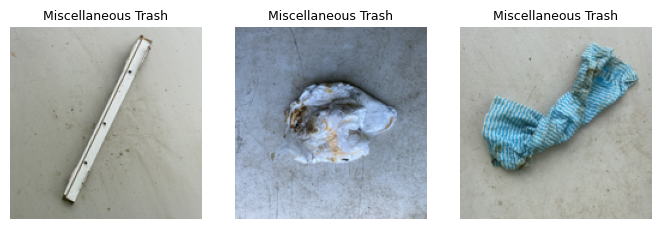

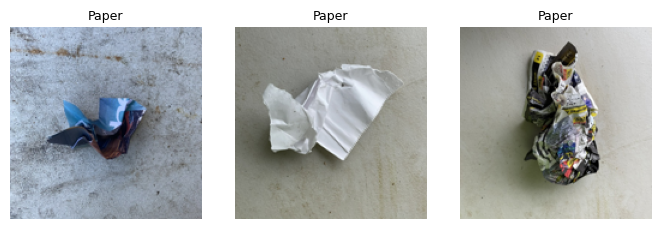

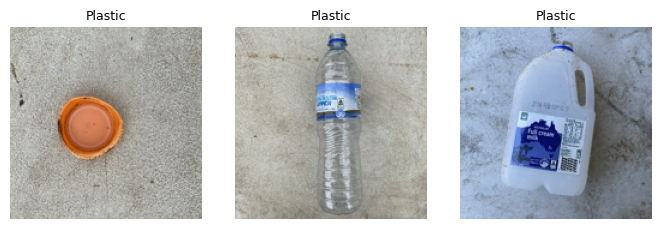

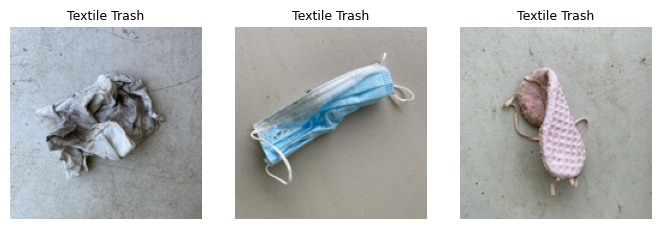

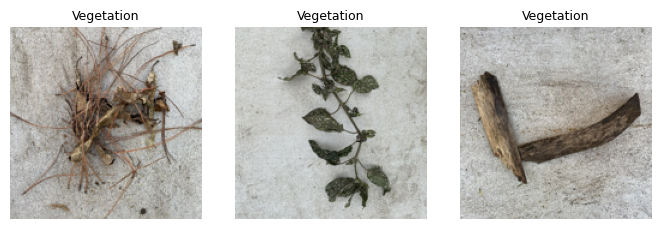

,n,w_mean,h_mean,area_median,aspect_mean,sharp_mean,color_mean
label,,,,,,,
Cardboard,461,524.0,524.0,274576.0,1.0,2469.41,30.45
Food Organics,411,524.0,524.0,274576.0,1.0,6136.12,24.29
Glass,420,524.0,524.0,274576.0,1.0,3722.81,17.69
Metal,790,524.0,524.0,274576.0,1.0,3497.37,14.95
Miscellaneous Trash,495,524.0,524.0,274576.0,1.0,3073.58,17.10
Paper,500,524.0,524.0,274576.0,1.0,4896.83,26.16
Plastic,921,524.0,524.0,274576.0,1.0,4520.97,21.61
Textile Trash,318,524.0,524.0,274576.0,1.0,2256.46,16.78
Vegetation,436,524.0,524.0,274576.0,1.0,17434.84,16.56


In [1]:
# ==== 1.1 Load and Explore the RealWaste Dataset ====

import os, math, random, glob
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Reproducibility
np.random.seed(42)
random.seed(42)
try:
    import tensorflow as tf
    tf.random.set_seed(42)
except Exception:
    pass

# ---- CONFIG: set your images root here
IMAGES_ROOT = Path("/Users/Kseniya/Downloads/realwaste-main/RealWaste")  # change if needed

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp")

def list_images_by_class(root: Path):
    rows = []
    if not root.exists():
        return pd.DataFrame(columns=["path","label","width","height","aspect","area","sharpness","colorfulness"])
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        label = cls_dir.name
        for p in cls_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                rows.append({"path": str(p), "label": label})
    return pd.DataFrame(rows)

def pil_read_size(p: str):
    try:
        with Image.open(p) as im:
            im = im.convert("RGB")
            w, h = im.size
            return w, h
    except Exception:
        return None, None

def variance_of_laplacian_np(img_rgb: np.ndarray) -> float:
    """Sharpness proxy without OpenCV. img_rgb: HxWx3 (0..255)."""
    # convert to gray
    g = (0.299*img_rgb[...,0] + 0.587*img_rgb[...,1] + 0.114*img_rgb[...,2]).astype(np.float32)
    # 3x3 Laplacian kernel
    k = np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=np.float32)
    # pad and convolve
    pad = 1
    gp = np.pad(g, pad, mode="edge")
    H, W = g.shape
    out = np.zeros_like(g)
    for i in range(H):
        for j in range(W):
            region = gp[i:i+3, j:j+3]
            out[i,j] = np.sum(region * k)
    return float(out.var())

def colorfulness_hasler(img_rgb: np.ndarray) -> float:
    """Hasler & Suesstrunk colorfulness metric."""
    R, G, B = img_rgb[...,0].astype(np.float32), img_rgb[...,1].astype(np.float32), img_rgb[...,2].astype(np.float32)
    rg = np.abs(R - G)
    yb = np.abs(0.5*(R + G) - B)
    std_rg, std_yb = rg.std(), yb.std()
    mean_rg, mean_yb = rg.mean(), yb.mean()
    return math.sqrt(std_rg**2 + std_yb**2) + 0.3*math.sqrt(mean_rg**2 + mean_yb**2)

def compute_image_stats(df: pd.DataFrame, sample_for_quality=300):
    """Adds width/height/aspect/area + sharpness & colorfulness (on a sample to save time)."""
    ws, hs = [], []
    for p in df["path"]:
        w, h = pil_read_size(p)
        ws.append(w); hs.append(h)
    df["width"], df["height"] = ws, hs
    df = df.dropna(subset=["width","height"])
    df["width"] = df["width"].astype(int)
    df["height"] = df["height"].astype(int)
    df["aspect"] = (df["width"] / df["height"]).round(4)
    df["area"] = df["width"] * df["height"]

    # quality metrics on a subset
    idxs = df.sample(min(sample_for_quality, len(df)), random_state=42).index if len(df) else []
    sharpness = pd.Series(np.nan, index=df.index, dtype=float)
    colorfulness = pd.Series(np.nan, index=df.index, dtype=float)
    for i in idxs:
        try:
            with Image.open(df.loc[i,"path"]) as im:
                im = im.convert("RGB")
                arr = np.array(im)
            sharpness[i] = variance_of_laplacian_np(arr)
            colorfulness[i] = colorfulness_hasler(arr)
        except Exception:
            pass
    df["sharpness"] = sharpness
    df["colorfulness"] = colorfulness
    return df

def show_examples(df: pd.DataFrame, per_class=3, img_size=160):
    classes = sorted(df["label"].unique())
    for cls in classes:
        sub = df[df["label"] == cls].sample(min(per_class, len(df[df["label"]==cls])), random_state=42)
        if len(sub)==0: 
            continue
        plt.figure(figsize=(per_class*2.3, 2.3))
        for i, (_, row) in enumerate(sub.iterrows(), start=1):
            plt.subplot(1, len(sub), i)
            try:
                im = Image.open(row["path"]).convert("RGB")
                im = im.resize((img_size, img_size))
                plt.imshow(im)
                plt.title(cls, fontsize=9)
                plt.axis("off")
            except Exception:
                pass
        plt.tight_layout()
        plt.show()

# ---- Run exploration
df = list_images_by_class(IMAGES_ROOT)

if len(df) == 0:
    print(f"[!] No images found under: {IMAGES_ROOT.resolve()}")
    print("Expected layout: data/images/<class_name>/*.jpg ... with classes:")
    print("paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass")
else:
    # Basic structure
    print("Total images:", len(df))
    print("Num classes :", df['label'].nunique())
    print("Classes     :", ", ".join(sorted(df['label'].unique().tolist())))

    # Category distribution
    counts = df["label"].value_counts().sort_index()
    display(pd.DataFrame({"count": counts}))

    plt.figure(figsize=(8,4))
    counts.plot(kind="bar")
    plt.title("Distribution of waste categories")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Image characteristics
    df = compute_image_stats(df)

    # Resolution histogram (area)
    plt.figure(figsize=(8,4))
    (df["area"]).plot(kind="hist", bins=30)
    plt.title("Image area (pixels) distribution")
    plt.xlabel("width * height")
    plt.tight_layout()
    plt.show()

    # Aspect ratio histogram
    plt.figure(figsize=(8,4))
    df["aspect"].plot(kind="hist", bins=30)
    plt.title("Aspect ratio distribution (width/height)")
    plt.xlabel("Aspect ratio")
    plt.tight_layout()
    plt.show()

    # Sharpness (variance of Laplacian) on sample
    if df["sharpness"].notna().sum() > 0:
        plt.figure(figsize=(8,4))
        df["sharpness"].dropna().plot(kind="hist", bins=30)
        plt.title("Sharpness distribution (variance of Laplacian, sample)")
        plt.xlabel("Sharpness")
        plt.tight_layout()
        plt.show()
        print("Sharpness (sample) — mean:", round(df["sharpness"].mean(), 3),
              "median:", round(df["sharpness"].median(), 3))

    # Colorfulness on sample
    if df["colorfulness"].notna().sum() > 0:
        plt.figure(figsize=(8,4))
        df["colorfulness"].dropna().plot(kind="hist", bins=30)
        plt.title("Colorfulness distribution (sample)")
        plt.xlabel("Colorfulness")
        plt.tight_layout()
        plt.show()
        print("Colorfulness (sample) — mean:", round(df["colorfulness"].mean(), 3),
              "median:", round(df["colorfulness"].median(), 3))

    # Few examples per class
    show_examples(df, per_class=3)

    # Quick summary table per class
    agg = df.groupby("label").agg(
        n=("path","count"),
        w_mean=("width","mean"),
        h_mean=("height","mean"),
        area_median=("area","median"),
        aspect_mean=("aspect","mean"),
        sharp_mean=("sharpness","mean"),
        color_mean=("colorfulness","mean"),
    ).round(2)
    display(agg)


### 1.2 Explore Text Datasets

Rows: 5000 | Columns: ['description', 'category', 'disposal_instruction', 'common_confusion', 'material_composition']
Detected columns: {'text': 'description', 'label': 'category', 'disposal': 'disposal_instruction', 'confusion': 'common_confusion', 'composition': 'material_composition'}


,count
category,
Cardboard,584
Food Organics,518
Glass,551
Metal,508
Miscellaneous Trash,578
Paper,506
Plastic,569
Textile Trash,586
Vegetation,600


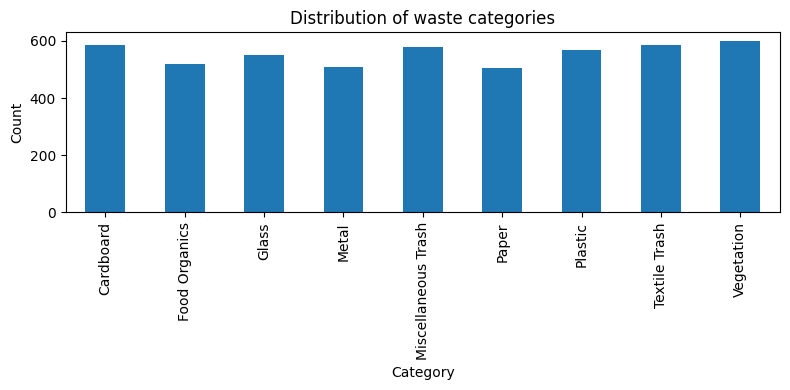

Description length — mean: 4.85 median: 5 max: 10


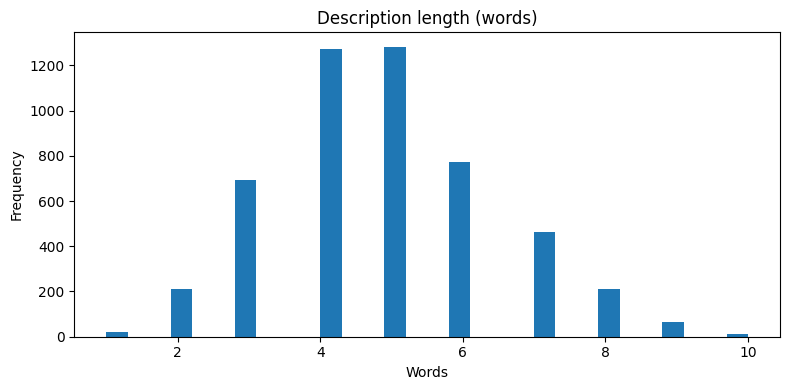

Disposal instruction length — mean: 7.49 median: 8


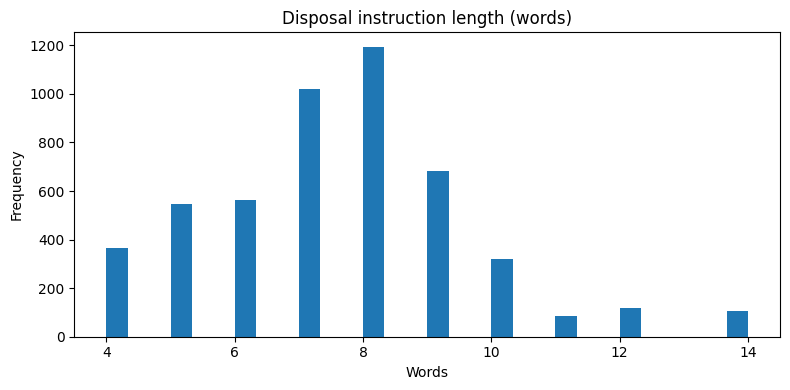


Top unigrams:


,term,count
0,sized,534
1,glass,424
2,bottle,342
3,paper,316
4,food,316
5,box,313
6,residue,309
7,plastic,280
8,metal,270
9,brand,247


Top bigrams:


,term,count
0,partially filled,182
1,fun sized,179
2,travel sized,178
3,regular sized,177
4,food residue,169
5,product remaining,161
6,multi colored,160
7,eco friendly,148
8,containing residue,140
9,label attached,132



Top TF-IDF terms per category (safe):


,category,term,mean_tfidf
0,Cardboard,box,0.082449
1,Cardboard,cardboard,0.044432
2,Cardboard,packaging,0.037906
3,Cardboard,food,0.029902
4,Cardboard,food packaging,0.024530
...,...,...,...
85,Vegetation,weeds,0.026282
86,Vegetation,sized,0.024129
87,Vegetation,houseplant,0.021389
88,Vegetation,potted,0.020618


In [2]:
# ==== 1.2a — Explore waste_descriptions.csv ====
# This cell:
# - Loads the file (auto-finds common locations)
# - Detects key columns (text/label/etc.)
# - Shows category distribution and description lengths
# - Lists top unigrams/bigrams and safe per-class TF-IDF keywords

from pathlib import Path
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Locate the dataset (edit if your path is different)
CANDIDATES = [
    Path("/mnt/data/waste_descriptions.csv"),
    Path("data/waste_descriptions.csv"),
    Path("waste_descriptions.csv"),
    Path.home() / "Downloads" / "waste_descriptions.csv",
]
desc_path = next((p for p in CANDIDATES if p.exists()), None)
assert desc_path is not None, "waste_descriptions.csv not found — update CANDIDATES to your actual path."

df = pd.read_csv(desc_path)
print("Rows:", len(df), "| Columns:", list(df.columns))

# Helper: pick a column name by likely variants
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

text_col = pick(df.columns, ["description","text","item_description","waste_description"])
label_col = pick(df.columns, ["category","label","waste_category","class"])
disp_col  = pick(df.columns, ["disposal_instruction","proper_disposal","disposal","instructions"])
conf_col  = pick(df.columns, ["common_confusion","confusion"])
comp_col  = pick(df.columns, ["material_composition","composition"])

print("Detected columns:", {"text":text_col, "label":label_col, "disposal":disp_col, "confusion":conf_col, "composition":comp_col})
assert text_col and label_col, "Need at least a text column (description) and a label column (category)."

# Basic cleaning
df[text_col]  = df[text_col].astype(str).str.strip()
df[label_col] = df[label_col].astype(str).str.strip()

# Category distribution
counts = df[label_col].value_counts().sort_index()
display(pd.DataFrame({"count": counts}))

plt.figure(figsize=(8,4))
counts.plot(kind="bar")
plt.title("Distribution of waste categories")
plt.xlabel("Category"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Description length analysis
desc_len = df[text_col].str.split().apply(len)
print("Description length — mean:", round(desc_len.mean(),2), 
      "median:", int(desc_len.median()), 
      "max:", int(desc_len.max()))

plt.figure(figsize=(8,4))
desc_len.plot(kind="hist", bins=30)
plt.title("Description length (words)")
plt.xlabel("Words")
plt.tight_layout(); plt.show()

# Disposal instruction length (if present)
if disp_col:
    disp_len = df[disp_col].dropna().astype(str).str.split().apply(len)
    print("Disposal instruction length — mean:", round(disp_len.mean(),2), 
          "median:", int(disp_len.median()))
    plt.figure(figsize=(8,4))
    disp_len.plot(kind="hist", bins=30)
    plt.title("Disposal instruction length (words)")
    plt.xlabel("Words")
    plt.tight_layout(); plt.show()

# Top unigrams/bigrams (global)
def top_terms(corpus, n=20, ngram=(1,1), stop="english"):
    vec = CountVectorizer(lowercase=True, stop_words=stop, ngram_range=ngram, min_df=2)
    X = vec.fit_transform(corpus)
    sums = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top_ix = np.argsort(-sums)[:n]
    return pd.DataFrame({"term": vocab[top_ix], "count": sums[top_ix]})

print("\nTop unigrams:")
display(top_terms(df[text_col], n=20, ngram=(1,1)))

print("Top bigrams:")
display(top_terms(df[text_col], n=20, ngram=(2,2)))

# SAFE per-class TF-IDF (handles small groups to avoid max_df < min_df error)
def top_tfidf_per_class_safe(frame, text_col, label_col, topk=10):
    rows = []
    for label, sub in frame.groupby(label_col):
        docs = sub[text_col].fillna("").astype(str).tolist()
        n = len(docs)
        if n == 0:
            continue

        # Relax vectorizer for small groups
        min_df = 2 if n >= 5 else 1
        max_df = 0.9 if n >= 5 else 1.0

        vec = TfidfVectorizer(
            lowercase=True,
            stop_words="english",
            ngram_range=(1,2),
            min_df=min_df,
            max_df=max_df
        )

        try:
            X = vec.fit_transform(docs)
        except ValueError:
            # Fallback for extremely tiny or odd groups
            vec = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,1), min_df=1, max_df=1.0)
            X = vec.fit_transform(docs)

        means = np.asarray(X.mean(axis=0)).ravel()
        if means.size == 0:
            continue

        top_ix = np.argsort(-means)[:min(topk, means.size)]
        vocab = np.array(vec.get_feature_names_out())
        for t, s in zip(vocab[top_ix], means[top_ix]):
            rows.append({"category": label, "term": t, "mean_tfidf": float(s)})
    return pd.DataFrame(rows)

print("\nTop TF-IDF terms per category (safe):")
display(top_tfidf_per_class_safe(df, text_col, label_col, topk=10))


Rows: 14 | Columns: ['policy_id', 'policy_type', 'categories_covered', 'effective_date', 'document_text', 'jurisdiction']
Detected columns: {'text': 'document_text', 'categories': 'categories_covered', 'jurisdiction': 'jurisdiction', 'policy_type': 'policy_type', 'date': 'effective_date'}
Document length (words) — mean: 101.79 median: 99


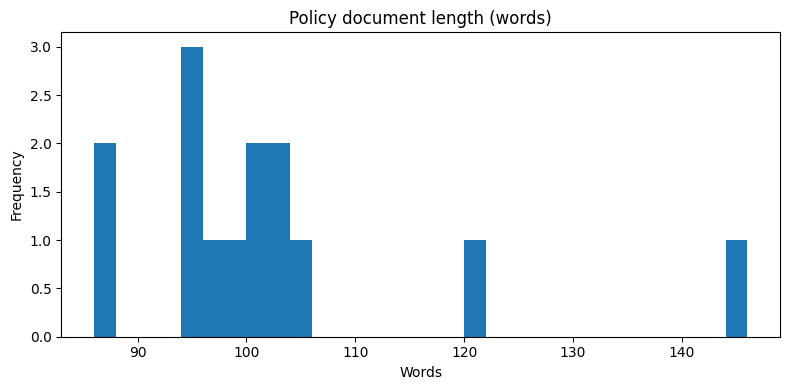

,count
category,
Cardboard,3
Food Organics,2
Glass,3
Metal,4
Miscellaneous Trash,4
Paper,1
Plastic,3
Textile Trash,3
Vegetation,4


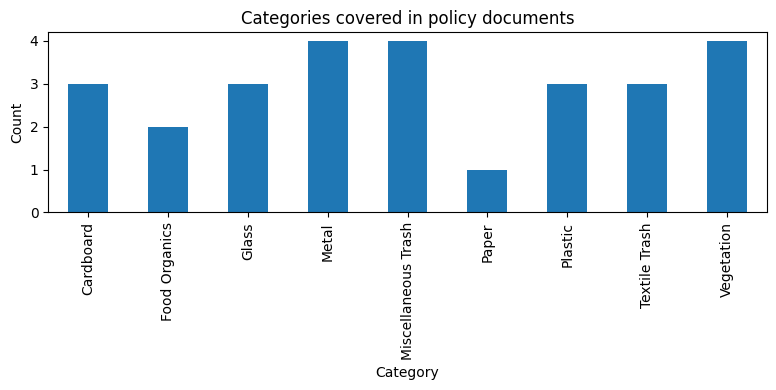

,jurisdiction_count
jurisdiction,
Metro City,14


,policy_type_count
policy_type,
Textile Trash Recycling Guidelines,1
Glass Recycling Guidelines,1
Food Organics Recycling Guidelines,1
Plastic Recycling Guidelines,1
Vegetation Recycling Guidelines,1
Cardboard Recycling Guidelines,1
Metal Recycling Guidelines,1
Paper Recycling Guidelines,1
Miscellaneous Trash Recycling Guidelines,1


,term,mean_tfidf
0,glass,0.117638
1,items,0.113440
2,containers,0.102291
3,cardboard,0.098737
4,recycling,0.089294
5,plastic,0.078997
6,paper,0.075889
7,packaging,0.075307
8,metal,0.072572
9,cans,0.072269


,category,term,mean_tfidf
0,Cardboard,cardboard,0.294909
1,Cardboard,glass,0.172859
2,Cardboard,boxes,0.165208
3,Cardboard,guidelines,0.150977
4,Cardboard,clean,0.149954
...,...,...,...
85,Vegetation,code,0.102070
86,Vegetation,containers code,0.102070
87,Vegetation,packaging,0.096103
88,Vegetation,cans,0.091878


In [3]:
# ==== 1.2b — Explore waste_policy_documents (CSV or JSON) ====
# This cell:
# - Loads policy docs from JSON or CSV (auto-finds common locations)
# - Reports document lengths, category coverage, jurisdictions/types
# - Shows top TF-IDF terms (global) and safe per-category keywords

import json
from pathlib import Path
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Locate policy file
JSON_CAND = [
    Path("/mnt/data/waste_policy_documents.json"),
    Path("data/waste_policy_documents.json"),
    Path("waste_policy_documents.json"),
    Path.home() / "Downloads" / "waste_policy_documents.json",
]
CSV_CAND = [
    Path("/mnt/data/waste_policy_documents.csv"),
    Path("data/waste_policy_documents.csv"),
    Path("waste_policy_documents.csv"),
    Path.home() / "Downloads" / "waste_policy_documents.csv",
]
pol_json = next((p for p in JSON_CAND if p.exists()), None)
pol_csv  = next((p for p in CSV_CAND if p.exists()), None)
assert pol_json or pol_csv, "Policy docs not found — add JSON or CSV and re-run."

# Load
if pol_json:
    with open(pol_json, "r", encoding="utf-8") as f:
        data = json.load(f)
    pdf = pd.json_normalize(data)
else:
    pdf = pd.read_csv(pol_csv)

print("Rows:", len(pdf), "| Columns:", list(pdf.columns))

# Column detection
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

text_col = pick(pdf.columns, ["document_text","text","body","content"])
cats_col = pick(pdf.columns, ["categories_covered","category","categories"])
jur_col  = pick(pdf.columns, ["jurisdiction","city","region"])
type_col = pick(pdf.columns, ["policy_type","type"])
date_col = pick(pdf.columns, ["effective_date","date","updated_at"])

print("Detected columns:", {"text":text_col, "categories":cats_col, "jurisdiction":jur_col, "policy_type":type_col, "date":date_col})
assert text_col, "Need a text column for the policy content."

# Document length distribution
pdf["_words"] = pdf[text_col].fillna("").astype(str).str.split().apply(len)
print("Document length (words) — mean:", round(pdf["_words"].mean(),2), 
      "median:", int(pdf["_words"].median()))

plt.figure(figsize=(8,4))
pdf["_words"].plot(kind="hist", bins=30)
plt.title("Policy document length (words)")
plt.xlabel("Words")
plt.tight_layout(); plt.show()

# Category coverage (if available)
def to_list(x):
    if isinstance(x, list): return x
    if pd.isna(x): return []
    if isinstance(x, str) and x.strip().startswith("["):
        try:
            arr = json.loads(x)
            if isinstance(arr, list): return arr
        except Exception:
            pass
    return [x]

if cats_col:
    pdf["_categories_list"] = pdf[cats_col].apply(to_list)
    cat_rows = [{"category": c} for lst in pdf["_categories_list"] for c in lst]
    cdf = pd.DataFrame(cat_rows)
    if len(cdf):
        counts = cdf["category"].astype(str).value_counts().sort_index()
        display(pd.DataFrame({"count": counts}))
        plt.figure(figsize=(8,4))
        counts.plot(kind="bar")
        plt.title("Categories covered in policy documents")
        plt.xlabel("Category"); plt.ylabel("Count")
        plt.tight_layout(); plt.show()

# Jurisdictions / policy types
if jur_col:
    display(pd.DataFrame({"jurisdiction_count": pdf[jur_col].astype(str).value_counts()}))
if type_col:
    display(pd.DataFrame({"policy_type_count": pdf[type_col].astype(str).value_counts()}))

# Global language profile: top TF-IDF terms
vec_global = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2), min_df=2, max_df=0.9)
Xg = vec_global.fit_transform(pdf[text_col].fillna(""))
means_g = np.asarray(Xg.mean(axis=0)).ravel()
vocab_g = np.array(vec_global.get_feature_names_out())
top_ix_g = np.argsort(-means_g)[:30]
display(pd.DataFrame({"term": vocab_g[top_ix_g], "mean_tfidf": means_g[top_ix_g]}))

# SAFE per-category keywords (handles small groups)
if cats_col:
    safe_rows = []
    cats = sorted({c for lst in pdf["_categories_list"] for c in lst})
    for c in cats:
        mask = pdf["_categories_list"].apply(lambda xs: c in xs)
        docs = pdf.loc[mask, text_col].fillna("").astype(str).tolist()
        n = len(docs)
        if n == 0:
            continue

        min_df = 2 if n >= 5 else 1
        max_df = 0.9 if n >= 5 else 1.0

        vec = TfidfVectorizer(
            lowercase=True,
            stop_words="english",
            ngram_range=(1,2),
            min_df=min_df,
            max_df=max_df
        )

        try:
            Xc = vec.fit_transform(docs)
        except ValueError:
            vec = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,1), min_df=1, max_df=1.0)
            Xc = vec.fit_transform(docs)

        means_c = np.asarray(Xc.mean(axis=0)).ravel()
        if means_c.size == 0:
            continue

        top_ix = np.argsort(-means_c)[:min(10, means_c.size)]
        vocab_c = np.array(vec.get_feature_names_out())
        for t, s in zip(vocab_c[top_ix], means_c[top_ix]):
            safe_rows.append({"category": str(c), "term": t, "mean_tfidf": float(s)})

    if safe_rows:
        display(pd.DataFrame(safe_rows))


### 1.3 Create Data Pipelines

In [4]:
# ==== 1.3 — Create Data Pipelines (TensorFlow, stratified train/val/test) ====
# What this cell does:
# - Scans a directory of class subfolders (e.g., RealWaste/paper, .../plastic, etc.)
# - Builds stratified splits: 70% train, 15% val, 15% test
# - Creates performant tf.data pipelines with caching/prefetch
# - Adds optional light data augmentation for training

import os, random, math, pathlib
import numpy as np
import tensorflow as tf

# Reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# ---------- CONFIG ----------
data_dir = pathlib.Path("RealWaste")  # <-- set this to the folder that has the 8 class subfolders
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH  = 224
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15  # must sum to 1.0
ALLOWED_EXTS = (".jpg", ".jpeg", ".png", ".webp", ".bmp")
# ----------------------------

# Validate directory
assert data_dir.exists() and data_dir.is_dir(), f"Directory not found: {data_dir}"

# List classes (subfolders)
class_names = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
assert num_classes > 0, "No class subfolders found."

# Gather filepaths + labels
filepaths, labels_str = [], []
for cls in class_names:
    cls_dir = data_dir / cls
    for root, _, files in os.walk(cls_dir):
        for fname in files:
            if fname.lower().endswith(ALLOWED_EXTS):
                filepaths.append(str(pathlib.Path(root) / fname))
                labels_str.append(cls)

image_count = len(filepaths)
print(f"Total images found: {image_count}")
assert image_count > 0, f"No images with {ALLOWED_EXTS} found under {data_dir}"

# Map class -> index
class_to_idx = {c: i for i, c in enumerate(class_names)}
labels_idx = np.array([class_to_idx[s] for s in labels_str], dtype=np.int32)

# Stratified split per class
def stratified_split(paths, y, train_frac, val_frac, test_frac, seed=42):
    rng = np.random.default_rng(seed)
    paths, y = np.array(paths), np.array(y)
    train_paths, val_paths, test_paths = [], [], []
    train_labels, val_labels, test_labels = [], [], []

    for cls_idx in sorted(set(y.tolist())):
        cls_mask = (y == cls_idx)
        cls_paths = paths[cls_mask]
        cls_labels = y[cls_mask]
        n = len(cls_paths)
        idxs = np.arange(n)
        rng.shuffle(idxs)

        n_train = int(n * train_frac)
        n_val   = int(n * val_frac)
        n_test  = n - n_train - n_val  # remainder to test

        tr_idx = idxs[:n_train]
        va_idx = idxs[n_train:n_train+n_val]
        te_idx = idxs[n_train+n_val:]

        for i in tr_idx:
            train_paths.append(cls_paths[i]); train_labels.append(int(cls_labels[i]))
        for i in va_idx:
            val_paths.append(cls_paths[i]);   val_labels.append(int(cls_labels[i]))
        for i in te_idx:
            test_paths.append(cls_paths[i]);  test_labels.append(int(cls_labels[i]))

    return (train_paths, np.array(train_labels)),
           (val_paths,   np.array(val_labels)),
           (test_paths,  np.array(test_labels))

(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = \
    stratified_split(filepaths, labels_idx, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=42)

print(f"Split sizes -> train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

# Optional: sanity check class balance
def counts_per_split(lbls, split_name):
    uniq, cnts = np.unique(lbls, return_counts=True)
    d = {class_names[int(k)]: int(v) for k, v in zip(uniq, cnts)}
    print(f"{split_name} per-class counts: {d}")
counts_per_split(train_labels, "train")
counts_per_split(val_labels,   "val")
counts_per_split(test_labels,  "test")

# TF helpers
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    # Read and decode image
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0  # scale to [0,1]; adjust if you do model-specific preprocessing
    y = tf.one_hot(label, depth=num_classes)
    return img, y

# Data augmentation for training (light and safe)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.1),
])

def make_dataset(paths, labels, training: bool):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        # Shuffle BEFORE mapping for better randomness over filenames
        shuffle_buf = max(1000, len(paths))
        ds = ds.shuffle(shuffle_buf, seed=42, reshuffle_each_iteration=True)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds      = make_dataset(train_paths, train_labels, training=True)
validation_ds = make_dataset(val_paths,   val_labels,   training=False)
test_ds       = make_dataset(test_paths,  test_labels,  training=False)

# Cardinalities
print("Batches ->",
      "train:",       tf.data.experimental.cardinality(train_ds).numpy(),
      "| validation:", tf.data.experimental.cardinality(validation_ds).numpy(),
      "| test:",       tf.data.experimental.cardinality(test_ds).numpy())

# Class weights (optional, useful if classes are imbalanced)
from collections import Counter
train_counts = Counter(train_labels.tolist())
total = sum(train_counts.values())
class_weights = {i: total/(num_classes * train_counts.get(i, 1)) for i in range(num_classes)}
print("Suggested class_weights:", {class_names[i]: round(w, 3) for i, w in class_weights.items()})

# Peek at one batch (optional visualization)
# for imgs, ys in train_ds.take(1):
#     print("Batch images:", imgs.shape, "Batch labels (one-hot):", ys.shape)
#     break

# Expose for later parts
PIPELINE_INFO = {
    "class_names": class_names,
    "num_classes": num_classes,
    "train_size": len(train_paths),
    "val_size": len(val_paths),
    "test_size": len(test_paths),
}
print("Pipeline ready:", PIPELINE_INFO)


IndentationError: unexpected indent (2376144621.py, line 85)

In [ ]:
# ==== 1.3A — Text preprocessing pipeline (descriptions) ====
# What this cell does:
# - Locates and loads waste_descriptions.csv
# - Cleans text (light, reproducible)
# - Tokenization via scikit-learn vectorizers
# - Stratified train/test split
# - Feature creation (TF-IDF word + character n-grams)
# - Saves artifacts for later modeling

from pathlib import Path
from IPython.display import display
import re, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# ---------- Locate dataset ----------
CANDIDATES = [
    Path("/mnt/data/waste_descriptions.csv"),
    Path("data/waste_descriptions.csv"),
    Path("waste_descriptions.csv"),
    Path.home() / "Downloads" / "waste_descriptions.csv",
]
desc_path = next((p for p in CANDIDATES if p.exists()), None)
assert desc_path is not None, "waste_descriptions.csv not found — update CANDIDATES to your actual path."

df = pd.read_csv(desc_path)
print("Rows:", len(df), "| Columns:", list(df.columns))

# ---------- Detect columns ----------
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

text_col = pick(df.columns, ["description","text","item_description","waste_description"])
label_col = pick(df.columns, ["category","label","waste_category","class"])
assert text_col and label_col, "Need at least a text column (description) and a label column (category)."

# ---------- Cleaning ----------
def clean_text(s: str) -> str:
    # Light, model-agnostic normalization. Do NOT over-clean (keep domain words).
    s = str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\s+", " ", s)            # collapse whitespace
    s = s.strip()
    return s

df[text_col]  = df[text_col].astype(str).map(clean_text)
df[label_col] = df[label_col].astype(str).str.strip()

# Optional: drop empty descriptions after cleaning
df = df[df[text_col].str.len() > 0].reset_index(drop=True)

# ---------- Stratified split ----------
X = df[text_col].values
y = df[label_col].values
le = LabelEncoder().fit(y)
y_idx = le.transform(y)
labels = le.classes_.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_idx, test_size=0.2, random_state=42, stratify=y_idx
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)} | Classes: {len(labels)}")

# ---------- Features: TF-IDF ----------
# Word-level TF-IDF (1–2 grams) + char-level TF-IDF (useful for OCR/noisy tokens)
word_tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9
)
char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=2,
    max_df=0.95
)

# Fit on TRAIN only, transform Train/Test
Xw_train = word_tfidf.fit_transform(X_train)
Xw_test  = word_tfidf.transform(X_test)

Xc_train = char_tfidf.fit_transform(X_train)
Xc_test  = char_tfidf.transform(X_test)

# Concatenate sparse features (word + char)
from scipy.sparse import hstack
X_train_feats = hstack([Xw_train, Xc_train]).tocsr()
X_test_feats  = hstack([Xw_test,  Xc_test]).tocsr()

print("Feature shapes:", X_train_feats.shape, X_test_feats.shape)

# ---------- Save artifacts ----------
ART_DIR = Path("artifacts/text_features")
ART_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(word_tfidf, ART_DIR / "word_tfidf.pkl")
joblib.dump(char_tfidf, ART_DIR / "char_tfidf.pkl")
joblib.dump((X_train_feats, y_train), ART_DIR / "train_features.pkl")
joblib.dump((X_test_feats,  y_test),  ART_DIR / "test_features.pkl")

with open(ART_DIR / "label_mapping.json", "w", encoding="utf-8") as f:
    json.dump({"labels": labels}, f, indent=2)

print("Saved to:", ART_DIR.resolve())

# ---------- Tiny sanity check ----------
print("Class distribution (train):")
display(pd.Series(y_train).value_counts().sort_index().rename(index=dict(enumerate(labels))))
print("Class distribution (test):")
display(pd.Series(y_test).value_counts().sort_index().rename(index=dict(enumerate(labels))))


In [ ]:
# ==== 1.3B — RAG document prep (policies) ====
# What this cell does:
# - Loads policy documents from JSON or CSV
# - Splits each document into overlapping chunks with metadata
# - Creates embeddings for retrieval:
#     * Preferred: Sentence-Transformers ("all-MiniLM-L6-v2") dense embeddings + FAISS index
#     * Fallback: TF-IDF sparse embeddings + cosine similarity (sklearn)
# - Saves artifacts + provides a quick search function

from pathlib import Path
import json, re, math
import numpy as np
import pandas as pd
import joblib

# ---------- Locate policy file ----------
JSON_CAND = [
    Path("/mnt/data/waste_policy_documents.json"),
    Path("data/waste_policy_documents.json"),
    Path("waste_policy_documents.json"),
    Path.home() / "Downloads" / "waste_policy_documents.json",
]
CSV_CAND = [
    Path("/mnt/data/waste_policy_documents.csv"),
    Path("data/waste_policy_documents.csv"),
    Path("waste_policy_documents.csv"),
    Path.home() / "Downloads" / "waste_policy_documents.csv",
]
pol_json = next((p for p in JSON_CAND if p.exists()), None)
pol_csv  = next((p for p in CSV_CAND if p.exists()), None)
assert pol_json or pol_csv, "Policy docs not found — add JSON or CSV and re-run."

# ---------- Load ----------
if pol_json:
    with open(pol_json, "r", encoding="utf-8") as f:
        data = json.load(f)
    pdf = pd.json_normalize(data)
else:
    pdf = pd.read_csv(pol_csv)

# ---------- Detect columns ----------
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

text_col = pick(pdf.columns, ["document_text","text","body","content"])
cats_col = pick(pdf.columns, ["categories_covered","category","categories"])
jur_col  = pick(pdf.columns, ["jurisdiction","city","region"])
type_col = pick(pdf.columns, ["policy_type","type"])
date_col = pick(pdf.columns, ["effective_date","date","updated_at"])
pid_col  = pick(pdf.columns, ["policy_id","id"])

assert text_col, "Need a text column for the policy content."
if pid_col is None:
    # Create a synthetic ID if missing
    pdf["_pid_auto"] = np.arange(len(pdf))
    pid_col = "_pid_auto"

# ---------- Cleaning + chunking ----------
def clean_text(s: str) -> str:
    s = str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"[ \t]+", " ", s)
    return s.strip()

def to_list(x):
    if isinstance(x, list): return x
    if pd.isna(x): return []
    if isinstance(x, str) and x.strip().startswith("["):
        try:
            arr = json.loads(x)
            if isinstance(arr, list): return arr
        except Exception:
            pass
    return [x] if x is not None else []

def chunk_text(text, target_chars=520, overlap=100):
    txt = clean_text(text)
    # split on blank lines to respect sections
    sections = re.split(r"\n\s*\n", txt)
    chunks = []
    buf = ""
    for sec in sections:
        if len(buf) + len(sec) + 1 <= target_chars:
            buf = (buf + "\n" + sec).strip()
        else:
            if buf: chunks.append(buf)
            if len(sec) > target_chars:
                # sliding window with overlap
                start = 0
                while start < len(sec):
                    end = min(len(sec), start + target_chars)
                    piece = sec[start:end]
                    chunks.append(piece.strip())
                    start = max(end - overlap, start + 1)
            else:
                buf = sec
    if buf:
        chunks.append(buf.strip())
    # remove tiny fragments
    chunks = [c for c in chunks if len(c.split()) >= 12]
    return chunks

rows = []
for _, r in pdf.iterrows():
    pid = r[pid_col]
    ptype = r[type_col] if type_col else None
    juri  = r[jur_col]  if jur_col  else None
    cats  = to_list(r[cats_col]) if cats_col else []
    text  = r[text_col] if pd.notna(r[text_col]) else ""
    parts = chunk_text(text, target_chars=520, overlap=100)
    if not parts:
        continue
    cats = cats if isinstance(cats, list) else [cats]
    cats = cats or [None]
    for cat in cats:
        for i, ch in enumerate(parts):
            rows.append({
                "policy_id": pid,
                "policy_type": ptype,
                "category": cat,
                "jurisdiction": juri,
                "chunk_ix": i,
                "text": ch
            })

chunks_df = pd.DataFrame(rows).reset_index(drop=True)
print("Chunks:", len(chunks_df))
display(chunks_df.head(10))

# ---------- Embeddings & index ----------
ART_DIR = Path("artifacts/rag")
ART_DIR.mkdir(parents=True, exist_ok=True)

# Try dense embeddings (Sentence-Transformers) + FAISS
use_dense = False
dense_model_name = "sentence-transformers/all-MiniLM-L6-v2"
faiss_available = False
try:
    from sentence_transformers import SentenceTransformer
    import faiss
    use_dense = True
    faiss_available = True
except Exception as e:
    print("[Info] Falling back to TF-IDF (Sentence-Transformers/FAISS not available):", e)

if use_dense:
    model = SentenceTransformer(dense_model_name)
    texts = chunks_df["text"].tolist()
    emb = model.encode(texts, batch_size=64, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    # Build FAISS index (Inner Product == cosine when vectors are normalized)
    dim = emb.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(emb.astype(np.float32))
    faiss.write_index(index, str(ART_DIR / "faiss_index.ip"))
    np.save(ART_DIR / "embeddings.npy", emb)
    chunks_df.to_csv(ART_DIR / "policy_chunks.csv", index=False)
    joblib.dump({"meta": chunks_df, "model_name": dense_model_name}, ART_DIR / "dense_meta.pkl")
    print("Saved dense embeddings + FAISS index to:", ART_DIR.resolve())
else:
    # Sparse TF-IDF fallback (works everywhere)
    from sklearn.feature_extraction.text import TfidfVectorizer
    vec = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2), min_df=1, max_df=1.0)
    X = vec.fit_transform(chunks_df["text"].fillna(""))
    chunks_df.to_csv(ART_DIR / "policy_chunks.csv", index=False)
    joblib.dump({"vectorizer": vec, "matrix": X, "meta": chunks_df}, ART_DIR / "tfidf_index.pkl")
    print("Saved TF-IDF index to:", ART_DIR.resolve())

# ---------- Quick search helper ----------
def search_policies(query, top_k=5, category=None, jurisdiction=None):
    if use_dense and faiss_available:
        import faiss
        # Load artifacts
        index = faiss.read_index(str(ART_DIR / "faiss_index.ip"))
        meta   = pd.read_csv(ART_DIR / "policy_chunks.csv")
        model  = SentenceTransformer(dense_model_name)
        q = model.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
        D, I = index.search(q, top_k*10)  # oversample then filter
        I = I[0]; D = D[0]
        results = []
        for i, score in zip(I, D):
            row = meta.iloc[int(i)]
            if category and str(row["category"]) != str(category): 
                continue
            if jurisdiction and str(row["jurisdiction"]) != str(jurisdiction):
                continue
            results.append({
                "score": float(score),
                "policy_id": row["policy_id"],
                "category": row["category"],
                "jurisdiction": row["jurisdiction"],
                "text": row["text"][:260] + ("..." if len(row["text"])>260 else "")
            })
            if len(results) >= top_k:
                break
        return pd.DataFrame(results)
    else:
        # TF-IDF cosine similarity
        from sklearn.metrics.pairwise import cosine_similarity
        bundle = joblib.load(ART_DIR / "tfidf_index.pkl")
        vec, X, meta = bundle["vectorizer"], bundle["matrix"], bundle["meta"]
        qv = vec.transform([query])
        sims = cosine_similarity(qv, X).ravel()
        idx = np.argsort(-sims)
        results = []
        taken = 0
        for i in idx:
            row = meta.iloc[int(i)]
            if category and str(row["category"]) != str(category): 
                continue
            if jurisdiction and str(row["jurisdiction"]) != str(jurisdiction):
                continue
            results.append({
                "score": float(sims[i]),
                "policy_id": row["policy_id"],
                "category": row["category"],
                "jurisdiction": row["jurisdiction"],
                "text": row["text"][:260] + ("..." if len(row["text"])>260 else "")
            })
            taken += 1
            if taken >= top_k:
                break
        return pd.DataFrame(results)

# ---------- Demo query (uncomment to try) ----------
# demo = search_policies("Rinse plastic bottle, remove cap | Metro City", top_k=5, category="Plastic", jurisdiction="Metro City")
# display(demo)


## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [ ]:
# ==== 2.1 — Preprocess Images (augmentation + normalization) ====
# What this cell does:
# - Reuses existing tf.data datasets (train_ds/validation_ds/test_ds) if defined
# - Otherwise, builds them from a directory of class subfolders
# - Applies light data augmentation to training only
# - Applies model-specific normalization (ResNet/MobileNet/EfficientNet)
# - Returns performant, prefetched pipelines

import pathlib, os, random
import numpy as np
import tensorflow as tf

# Reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# ---------- CONFIG ----------
# If datasets are not already created earlier, set your images root here:
data_dir = pathlib.Path("RealWaste")  # folder that directly contains the 8 class subfolders
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH  = 224
BACKBONE   = "resnet50"  # one of: "resnet50", "mobilenet_v2", "efficientnet_b0"
# ----------------------------

# Pick preprocess function for the chosen backbone
def get_preprocess(backbone: str):
    b = backbone.lower()
    if b == "resnet50":
        from tensorflow.keras.applications.resnet50 import preprocess_input
    elif b == "mobilenet_v2":
        from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    elif b == "efficientnet_b0":
        from tensorflow.keras.applications.efficientnet import preprocess_input
    else:
        raise ValueError("Unsupported BACKBONE. Choose resnet50 | mobilenet_v2 | efficientnet_b0")
    return preprocess_input

preprocess_input = get_preprocess(BACKBONE)

# Data augmentation (training only) — light & safe
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.03),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.05),
    ],
    name="augment",
)

AUTOTUNE = tf.data.AUTOTUNE

def apply_preprocessing(ds, training: bool):
    # Map to float32 first, then apply augmentation (train only), then model preprocess
    def _map(img, y):
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # ensure target size
        img = tf.cast(img, tf.float32)
        if training:
            img = data_augmentation(img, training=True)
        # Many preprocess_input expect values in [0,255]; rescale back if input is in [0,1]
        # Detect range roughly (first call cost is minor):
        # We'll assume ds upstream delivers [0,1] if created via image_dataset_from_directory with default settings.
        # Multiply to [0,255] before preprocess_input for safety:
        img = preprocess_input(img * 255.0)
        return img, y

    return (
        ds.map(_map, num_parallel_calls=AUTOTUNE)
          .prefetch(AUTOTUNE)
    )

# Helper: build datasets if they don't exist yet
def build_datasets_if_needed():
    g = globals()
    if all(k in g for k in ["train_ds", "validation_ds", "test_dataset"]) or \
       all(k in g for k in ["train_ds", "validation_ds", "test_ds"]):
        # Already have datasets; normalize naming
        if "test_ds" in g:
            return g["train_ds"], g["validation_ds"], g["test_ds"]
        else:
            return g["train_ds"], g["validation_ds"], g["test_dataset"]

    # Otherwise build from directory structure (80/10/10 via val split halving)
    assert data_dir.exists(), f"Directory not found: {data_dir}"
    train_raw = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=True,
    )
    val_raw = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=True,
    )
    # Split validation into val/test equally
    val_batches = tf.data.experimental.cardinality(val_raw)
    test_raw = val_raw.take(val_batches // 2)
    val_raw  = val_raw.skip(val_batches // 2)
    return train_raw, val_raw, test_raw

# Build or reuse raw datasets
train_raw, val_raw, test_raw = build_datasets_if_needed()

# Cache before preprocessing for I/O efficiency
train_raw = train_raw.cache()
val_raw   = val_raw.cache()
test_raw  = test_raw.cache()

# Apply preprocessing
train_ds      = apply_preprocessing(train_raw, training=True)
validation_ds = apply_preprocessing(val_raw,   training=False)
test_ds       = apply_preprocessing(test_raw,  training=False)

# Introspection
print("Batches ->",
      "train:",       tf.data.experimental.cardinality(train_ds).numpy(),
      "| validation:", tf.data.experimental.cardinality(validation_ds).numpy(),
      "| test:",       tf.data.experimental.cardinality(test_ds).numpy())

# Quick sanity check on value ranges and shapes (uncomment to inspect)
# for imgs, ys in train_ds.take(1):
#     print("train batch:", imgs.shape, ys.shape, imgs.dtype, ys.dtype)
#     print("min/max:", tf.reduce_min(imgs).numpy(), tf.reduce_max(imgs).numpy())
#     break


### 2.2 Implement CNN Model with Transfer Learning

In [ ]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

# Your code here

### 2.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

# Your code here

In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here

### 2.4 Fine-tune the Model

In [ ]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed

# Your code here

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [ ]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

# Your code here

### 3.2 Implement Text Classification Model

In [ ]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

# Your code here

### 3.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Your code here

In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Your code here

### 3.4 Create Classification Function

In [ ]:
# TODO: Create a function that takes a text description and returns the predicted waste category

def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    # Your code here
    pass

## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [ ]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval

# Your code here

### 4.2 Implement RAG-based System

In [ ]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

# Your code here

### 4.3 Adjust and Evaluate the System

In [ ]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters

# Your code here

In [ ]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

# Your code here

### 4.4 Create Instruction Generation Function

In [ ]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    # Your code here
    pass

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow

# Your code here

### 5.2 Implement Integrated Assistant

In [ ]:
# TODO: Implement the integrated waste management assistant

def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"

    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """
    # Your code here
    pass

### 5.3 Evaluate the Integrated System

In [ ]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance

# Your code here

## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.